In [12]:
from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel
from advectionGP.kernels import EQ
from advectionGP.test import TestKernels

import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data

In [13]:
# generate sensor locations with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(2,15,5) # lower time
xloc=np.linspace(5,15,2) # x locations
yloc=np.linspace(5,15,2) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
X[:,1] = X[:,0]+1

u = 0.4
k_0 = 0.1
noiseSD = 0.05

N_feat=100 # number of features used to approximate GP
boundary = ([0,0,0],[20,20,20]) # corners of the grid
k = EQ(4.0, 2.0) # generate EQ kernel
sensors = FixedSensorModel(X,1) # establish sensor model
res = [80,40,40]
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,u=u,k_0=k_0) #initiate PDE model

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute test source
source=m.computeSourceFromPhi(z) # Compute test source
conc=m.computeConcentration(source) # Compute test concentration
y= m.computeObservations(addNoise='TRUE') # Compute observations with noise

The data generated is just the observations (y) at the sensors/observation times defined in X.

This is our synthetic source...

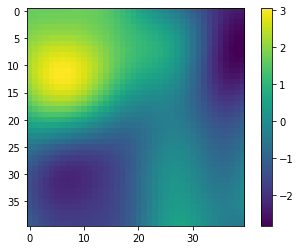

In [14]:
plt.imshow(source[10])
plt.colorbar()

And the synthetic data we will give our adjoint method, is:

In [15]:
y

array([ 6.73899859, -0.25963865, 13.37809983,  0.7598887 , 14.62667281,
        0.08537918, 13.83432487, -4.22423338, 10.64159042, -5.92037759,
       -4.75277831,  0.38932594, -9.10647513,  0.23745153, -8.44323773,
        2.70971947, -4.30127395,  4.86736634,  0.18450548,  3.4764963 ])

20 observations


(0.0, 20.0)

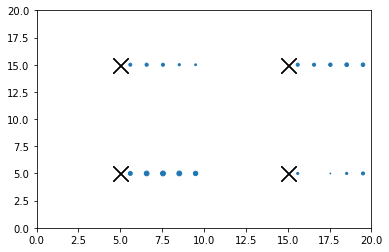

In [16]:
print("%d observations" % len(X))
plt.plot(X[:,2],X[:,3],'xk',markersize=15)
plt.scatter(X[:,2]+X[:,0]*0.3,X[:,3],y-np.min(y))
plt.xlim(m.boundary[0][1],m.boundary[1][1])
plt.ylim(m.boundary[0][2],m.boundary[1][2])

# Try to predict the source from the observations...

In [17]:
k = EQ(4.0, 2.0) # generate EQ kernel
sensors = FixedSensorModel(X,1)
N_feat = 100
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,u=u,k_0=k_0) #initiate PDE model
X1 = m.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = m.computeZDistribution(y) # Infers z vector mean and covariance
source2 = m.computeSourceFromPhi(meanZ) # Generates estimated source using inferred mean

Calculating Adjoints...
19/20 
Calculating Phis...
99/100 


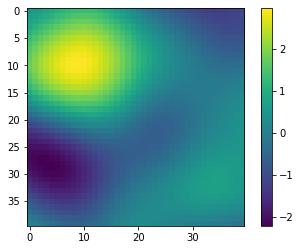

In [18]:
plt.imshow(source2[10])
plt.colorbar()

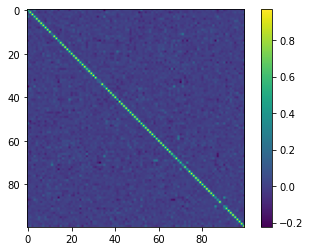

In [19]:
plt.imshow(covZ)
plt.colorbar()

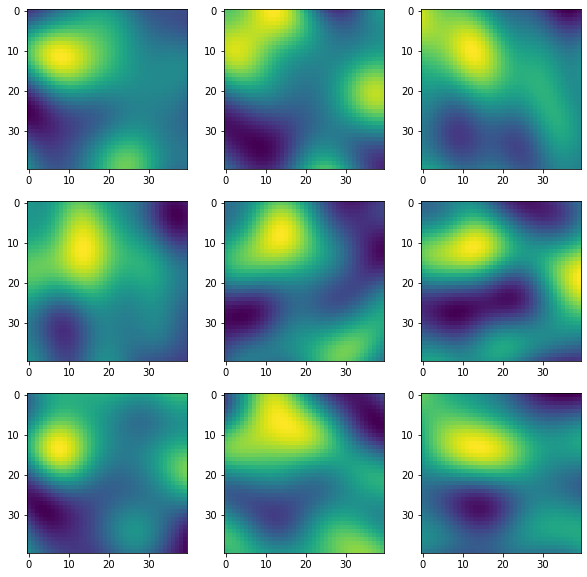

In [20]:
plt.figure(figsize=[10,10])
for sample_i in range(9):
    plt.subplot(3,3,sample_i+1)
    z = np.random.multivariate_normal(meanZ,covZ)
    source = m.computeSourceFromPhi(z) # Generates estimated source using inferred mean
    plt.imshow(source[10])

In [21]:
Nsamps = 30
results = np.zeros(np.r_[res,Nsamps])
for sample_i in range(Nsamps):
    z = np.random.multivariate_normal(meanZ,covZ)
    results[:,:,:,sample_i] = m.computeSourceFromPhi(z) 

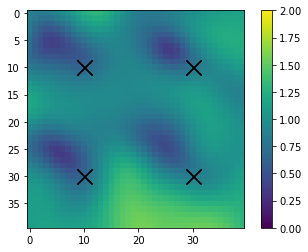

In [34]:
plt.imshow(np.std(results,3)[32,:,:])
plt.clim([0,2])
plt.colorbar()
plt.plot(X[:,2]*2,X[:,3]*2,'xk',markersize=15)